## Data prep

In [153]:
import pandas as pd
import numpy as np
import glob
import pickle

In [2]:
col_to_keep = ["DateTime Clean", "DiagnosticType", "CarNo", "NameOfStation", "EventState", "Wagen Clean","Description Clean"]
to_read = ["Beacon reader new ASDO data","Standstill (v<0.2 km/h)", "Operation mode setpoint STATION - Door release is active",
           "Trace recording message", "v<3 km/h - Door control released", "HW or SW Door loop open - local Unit"]
SW_train = ["707014", "707015", "707016", "707017", "707018"]
SE_train = ["707009", "707011", "707012", "707013", "707028"]

In [ ]:
data_dict = {}
for file in glob.glob("*.xlsx"):
    name = file[0:6]
    data = pd.read_excel(file)
    data = data[data["HeaderType"] != "HeaderType"]
    data = data[col_to_keep]
    data_fil = data[data["Description Clean"].isin(to_read)].reset_index()
    data_dict[name] = data_fil

In [ ]:
with open('data_dict.pickle', 'wb') as f:
    pickle.dump(data_dict, f)

## Data manipulation

In [3]:
with open('data_dict.pickle', 'rb') as f:
    data_dict = pickle.load(f)

In [314]:
data_fil = data_dict[SW_train[0]]
door_list = data_fil[data_fil["Description Clean"] == "Trace recording message"]["NameOfStation"].unique().tolist()

In [87]:
door_dict_day = {}
for i in [0,1]:
    door_dict_train = {}
    for train, data in data_dict.items():
        day = min(data["DateTime Clean"].dt.day)
        door_dict = {}
        for door in door_list:
            data = data[data["DateTime Clean"].dt.day == day + i]
            df_test = data[data["NameOfStation"] == door].reset_index()
            df_test["Status"] = np.where(df_test.index%2 == 0, 0, 1)
            df_test["Time_diff (sec)"] = (df_test["DateTime Clean"] - df_test["DateTime Clean"].shift(1)).dt.total_seconds()
            door_dict[door] = df_test.drop(columns="level_0")
        door_dict_train[train] = door_dict
    door_dict_day[f"Day {i + 1}"] = door_dict_train

## Average door operation

In [38]:
series_day = {}
for day, door_dict_train in door_dict_day.items():
    list_series = []
    for train, door_dict in door_dict_train.items():
        dict_series = {}
        dict_series["train_nb"] = str(train)
        for door in door_dict.keys():
            dict_series[door] = len(door_dict[door])
        list_series.append(dict_series)
    series_day[day] = list_series

In [58]:
df_dict = {}
for day, series in series_day.items():
    df_fin = pd.DataFrame.from_dict(series)
    df_fin["total"] = df_fin.sum(numeric_only = True, axis=1)
    df_dict[day] = df_fin

In [300]:
df_ave = ((df_dict["Day 2"].select_dtypes("number") + df_dict["Day 2"].select_dtypes("number"))/2)
df_ave.insert(loc=0, column='Train', value=df_dict["Day 2"]["train_nb"])
df_ave

,Train,DOOR--14,DOOR--A2,DOOR--23,DOOR--A1,DOOR--63,DOOR--64,DOOR--F2,DOOR--F1,DOOR--13,...,DOOR--61,DOOR--22,DOOR--12,DOOR--11,DOOR--24,DOOR--16,DOOR--A6,DOOR--15,DOOR--A5,total
0,707011,58.0,84.0,80.0,82.0,88.0,82.0,87.0,92.0,60.0,...,90.0,80.0,90.0,73.0,74.0,12.0,12.0,36.0,0.0,1806.0
1,707018,85.0,164.0,121.0,158.0,139.0,133.0,138.0,153.0,117.0,...,98.0,102.0,72.0,59.0,126.0,58.0,66.0,37.0,163.0,2769.0
2,707028,64.0,112.0,92.0,128.0,105.0,98.0,118.0,98.0,77.0,...,66.0,76.0,82.0,56.0,89.0,18.0,0.0,13.0,10.0,1808.0
3,707016,76.0,219.0,156.0,156.0,166.0,164.0,164.0,176.0,96.0,...,198.0,162.0,125.0,97.0,136.0,29.0,65.0,22.0,246.0,3670.0
4,707012,188.0,132.0,163.0,160.0,170.0,158.0,144.0,141.0,190.0,...,144.0,154.0,156.0,185.0,160.0,0.0,42.0,4.0,32.0,3058.0
5,707013,93.0,145.0,118.0,155.0,112.0,101.0,106.0,137.0,98.0,...,80.0,60.0,66.0,90.0,100.0,11.0,8.0,22.0,0.0,2040.0
6,707014,116.0,198.0,164.0,219.0,163.0,150.0,200.0,168.0,143.0,...,114.0,114.0,94.0,88.0,157.0,34.0,72.0,33.0,298.0,3433.0
7,707017,84.0,221.0,150.0,193.0,162.0,160.0,171.0,190.0,122.0,...,172.0,184.0,140.0,110.0,133.0,19.0,69.0,24.0,262.0,3790.0
8,707009,116.0,108.0,124.0,93.0,120.0,108.0,100.0,118.0,124.0,...,189.0,196.0,172.0,158.0,125.0,6.0,4.0,0.0,52.0,2966.0
9,707015,114.0,172.0,132.0,170.0,135.0,134.0,136.0,140.0,134.0,...,119.0,96.0,90.0,56.0,127.0,37.0,62.0,16.0,230.0,2912.0


In [304]:
df_SE = df_ave[df_ave["Train"].isin(SE_train)].describe()
df_SE.loc[["mean"]]

,DOOR--14,DOOR--A2,DOOR--23,DOOR--A1,DOOR--63,DOOR--64,DOOR--F2,DOOR--F1,DOOR--13,DOOR--21,...,DOOR--61,DOOR--22,DOOR--12,DOOR--11,DOOR--24,DOOR--16,DOOR--A6,DOOR--15,DOOR--A5,total
mean,103.8,116.2,115.4,123.6,119.0,109.4,111.0,117.2,109.8,110.2,...,113.8,113.2,113.2,112.4,109.6,9.4,13.2,15.0,18.8,2335.6


In [305]:
df_SW = df_ave[df_ave["Train"].isin(SW_train)].describe().loc[["mean"]]
df_SE = df_ave[df_ave["Train"].isin(SE_train)].describe().loc[["mean"]]
df_fleet = pd.concat([df_SW, df_SE]).reset_index()
df_fleet["index"] = ["SouthWest", "SouthEast"]

In [306]:
df_fleet_2 = df_fleet.rename(columns={"index":"Fleet"})
df_fleet_2

,Fleet,DOOR--14,DOOR--A2,DOOR--23,DOOR--A1,DOOR--63,DOOR--64,DOOR--F2,DOOR--F1,DOOR--13,...,DOOR--61,DOOR--22,DOOR--12,DOOR--11,DOOR--24,DOOR--16,DOOR--A6,DOOR--15,DOOR--A5,total
0,SouthWest,95.0,194.8,144.6,179.2,153.0,148.2,161.8,165.4,122.4,...,140.2,131.6,104.2,82.0,135.8,35.4,66.8,26.4,239.8,3314.8
1,SouthEast,103.8,116.2,115.4,123.6,119.0,109.4,111.0,117.2,109.8,...,113.8,113.2,113.2,112.4,109.6,9.4,13.2,15.0,18.8,2335.6


<AxesSubplot:>

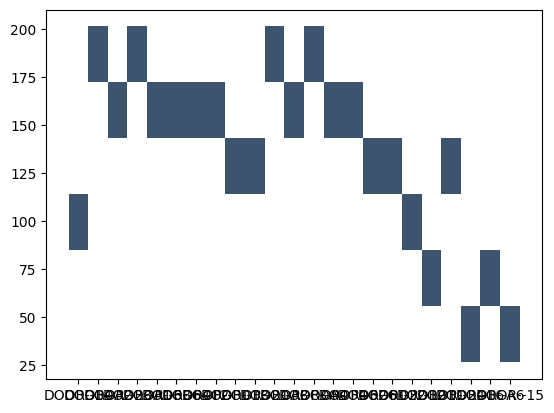

In [308]:
sns.histplot(x=df_fleet_2.columns.tolist()[1:-2],y=df_fleet_2.head(1).values.tolist()[0][1:-2] )

## Average time between door operation

In [233]:
test_dict = door_dict_day["Day 1"]["707011"]["DOOR--A5"]
test_dict[test_dict["Status"] == 1]

,index,DateTime Clean,DiagnosticType,CarNo,NameOfStation,EventState,Wagen Clean,Description Clean,Status,Time_diff (sec)


/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Time_diff (sec)'>

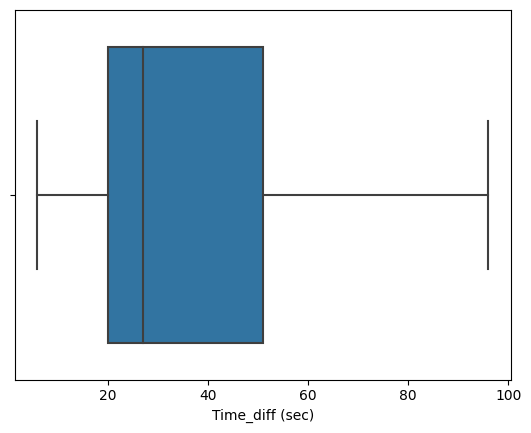

In [206]:
import seaborn as sns
sns.boxplot(test["Time_diff (sec)"])

In [211]:
time_day_dict = {}
for day, train_data in door_dict_day.items():
    time_train_dict = {}
    for train, door_dict in train_data.items():
        time_door_dict = {}
        for door, data in door_dict.items():
            averge_open = data[(data["Status"] == 1) & (data["Time_diff (sec)"]<150)]["Time_diff (sec)"].mean()
            avergae_close = data[data["Status"] == 0]["Time_diff (sec)"].mean()
            average_door = data["Time_diff (sec)"].mean()
            time_door_dict[door] = {"Open": averge_open, "Close": avergae_close, "Any": average_door}
        time_train_dict[train] = time_door_dict
    time_day_dict[day] = time_train_dict

In [231]:
time_day_dict["Day 1"]["707011"]["DOOR--A5"]

{'Open': nan, 'Close': nan, 'Any': nan}

In [238]:
def make_average_df(status):

    series_time = {}
    for day, time_dict_train in time_day_dict.items():
        list_series = []
        for train, time_door_dict in time_dict_train.items():
            dict_series_time = {}
            dict_series_time["train_nb"] = str(train)
            for door, data in time_door_dict.items():
                dict_series_time[door] = data[status]
            list_series.append(dict_series_time)
        series_time[day] = list_series

    df_time_dict = {}
    for day, series in series_time.items():
        df_fin = pd.DataFrame.from_dict(series)
        df_fin["total"] = df_fin.mean(numeric_only = True, axis=1)
        df_time_dict[day] = df_fin

    df_ave_time = ((df_time_dict["Day 1"].select_dtypes("number") + df_time_dict["Day 2"].select_dtypes("number"))/2)
    df_ave_time.insert(loc=0, column='Train', value=df_time_dict["Day 2"]["train_nb"])
    return df_ave_time

In [254]:
list_status = ['Open', 'Close', 'Any']

time_df_dict = {}
time_fleet_dict = {}
for status in list_status:
    df = make_average_df(status).round(decimals=1)
    df_SW_time = df[df["Train"].isin(SW_train)].describe().loc[["mean"]].round(decimals=1)
    df_SE_time = df[df["Train"].isin(SE_train)].describe().loc[["mean"]].round(decimals=1)
    df_fleet = pd.concat([df_SW_time, df_SE_time]).reset_index()
    df_fleet["index"] = ["SouthWest", "SouthEast"]
    df_fleet_2 = df_fleet.rename(columns={"index":"Fleet"})
    time_df_dict[status] = df
    time_fleet_dict[status] = df_fleet_2

In [255]:
time_df_dict["Open"]

,Train,DOOR--14,DOOR--A2,DOOR--23,DOOR--A1,DOOR--63,DOOR--64,DOOR--F2,DOOR--F1,DOOR--13,...,DOOR--61,DOOR--22,DOOR--12,DOOR--11,DOOR--24,DOOR--16,DOOR--A6,DOOR--15,DOOR--A5,total
0,707011,41.0,35.3,36.0,36.7,37.2,39.5,36.3,35.4,40.3,...,36.8,36.5,52.5,51.3,47.7,30.2,21.5,26.8,NaN,38.3
1,707018,39.0,36.7,32.3,30.1,31.0,39.6,44.5,30.4,36.2,...,25.0,27.4,26.5,38.7,35.0,20.9,30.6,17.8,42.8,32.1
2,707028,49.6,35.6,35.6,49.9,38.0,33.6,33.7,33.9,34.6,...,36.7,54.5,42.0,40.7,32.0,13.0,NaN,22.7,31.1,37.6
3,707016,30.3,46.5,29.3,28.4,28.4,29.2,27.4,28.8,31.5,...,34.8,24.0,30.2,25.1,27.0,NaN,29.6,14.1,67.1,30.4
4,707012,32.1,37.0,44.2,37.8,35.1,34.3,35.4,39.0,41.3,...,38.1,38.4,34.7,44.2,32.2,NaN,25.9,48.2,12.2,37.4
5,707013,45.8,45.3,46.4,46.6,44.9,45.3,34.0,48.7,47.8,...,43.9,44.1,38.8,37.7,53.2,11.5,12.4,9.9,NaN,38.8
6,707014,48.7,35.0,39.0,43.2,49.1,51.1,34.2,40.9,47.1,...,25.4,27.4,27.2,27.8,29.7,NaN,NaN,NaN,NaN,34.2
7,707017,27.8,39.2,25.8,65.7,27.7,26.7,108.0,67.9,27.3,...,28.7,42.5,31.8,56.0,35.5,16.4,33.2,17.2,34.4,38.9
8,707009,33.3,44.4,33.9,50.8,34.8,32.9,33.9,43.0,40.9,...,49.7,37.3,38.8,37.5,60.5,29.8,22.4,NaN,17.4,39.4
9,707015,26.0,37.6,32.4,28.9,31.0,32.3,33.8,30.8,32.8,...,33.8,28.2,26.6,27.2,31.1,26.6,30.0,15.8,32.6,29.5


In [256]:
time_fleet_dict["Close"]

,Fleet,DOOR--14,DOOR--A2,DOOR--23,DOOR--A1,DOOR--63,DOOR--64,DOOR--F2,DOOR--F1,DOOR--13,...,DOOR--61,DOOR--22,DOOR--12,DOOR--11,DOOR--24,DOOR--16,DOOR--A6,DOOR--15,DOOR--A5,total
0,SouthWest,1372.1,504.4,830.3,582.6,750.4,827.4,579.4,785.6,823.9,...,923.8,997.6,1126.1,1285.4,802.8,1723.6,863.9,3043.8,314.5,936.6
1,SouthEast,763.2,955.9,1052.5,682.6,961.7,1025.3,1334.3,895.4,1065.1,...,811.6,843.2,773.2,891.2,775.3,3812.4,8755.2,3020.6,4523.2,1351.9


<AxesSubplot:>

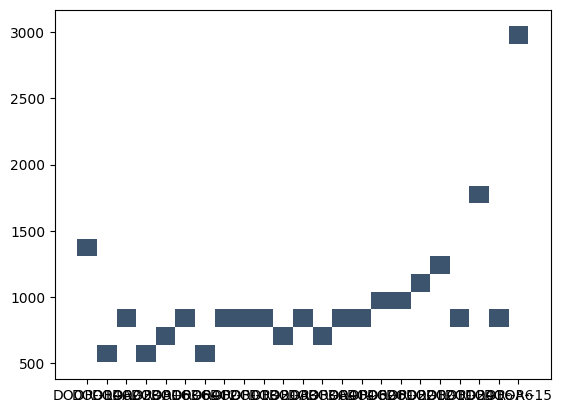

In [350]:
sns.histplot(x=time_fleet_dict["Close"].columns.tolist()[1:-2],y=time_fleet_dict["Close"].head(1).values.tolist()[0][1:-2] )

## Average time between stations

In [399]:
train_list = SW_train + SE_train
average_time_station = {}
for train in train_list:
    mask = (data_dict[train]["Description Clean"] == "Beacon reader new ASDO data") | (data_dict[train]["Description Clean"] == "Standstill (v<0.2 km/h)") | (data_dict[train]["Description Clean"] =="Operation mode setpoint STATION - Door release is active")
    df_test = data_dict[train][mask]
    df_test["temp"] = df_test["Description Clean"].shift(1)
    df_test["Station"] = (df_test["temp"] == "Beacon reader new ASDO data") & (df_test["Description Clean"] == "Standstill (v<0.2 km/h)")
    df_test.drop(columns="temp", inplace = True)
    time_mean = df_test[df_test["Station"]== True]["Time_between_station"] = (df_test[df_test["Station"]== True]["DateTime Clean"] - df_test[df_test["Station"]== True]["DateTime Clean"].shift(1)).dt.total_seconds()
    average_time_station[train] = time_mean[time_mean<10000].mean()

/tmp/ipykernel_459/2268615801.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["temp"] = df_test["Description Clean"].shift(1)
/tmp/ipykernel_459/2268615801.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Station"] = (df_test["temp"] == "Beacon reader new ASDO data") & (df_test["Description Clean"] == "Standstill (v<0.2 km/h)")
/tmp/ipykernel_459/2268615801.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

In [401]:
train = "707028"
mask = (data_dict[train]["Description Clean"] == "Beacon reader new ASDO data") | (data_dict[train]["Description Clean"] == "Standstill (v<0.2 km/h)") | (data_dict[train]["Description Clean"] =="Operation mode setpoint STATION - Door release is active")
df_test = data_dict[train][mask]
df_test["temp"] = df_test["Description Clean"].shift(1)
df_test["Station"] = (df_test["temp"] == "Beacon reader new ASDO data") & (df_test["Description Clean"] == "Standstill (v<0.2 km/h)")
df_test.drop(columns="temp", inplace = True)
time_mean = df_test[df_test["Station"]== True]["Time_between_station"] = (df_test[df_test["Station"]== True]["DateTime Clean"] - df_test[df_test["Station"]== True]["DateTime Clean"].shift(1)).dt.total_seconds()
time_mean[time_mean>1000]

/tmp/ipykernel_459/3799457868.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["temp"] = df_test["Description Clean"].shift(1)
/tmp/ipykernel_459/3799457868.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Station"] = (df_test["temp"] == "Beacon reader new ASDO data") & (df_test["Description Clean"] == "Standstill (v<0.2 km/h)")
/tmp/ipykernel_459/3799457868.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

127      1285.0
421      1550.0
1639     1034.0
2191     1722.0
2391     1042.0
3248     1372.0
4450     1015.0
5427     1138.0
5756     1499.0
5870    22418.0
6336     1781.0
6948    19686.0
7647     1579.0
8378     1793.0
8888     2735.0
Name: DateTime Clean, dtype: float64

In [400]:
average_time_station

{'707014': 248.91935483870967,
 '707015': 269.82,
 '707016': 248.921146953405,
 '707017': 257.06681034482756,
 '707018': 257.37083333333334,
 '707009': 311.5073170731707,
 '707011': 279.4617486338798,
 '707012': 286.55610972568576,
 '707013': 329.2209944751381,
 '707028': 279.4672131147541}

In [379]:
sum(list(average_time_station.values()))/len(list(average_time_station.values()))

385.8689680102122